**Author:** Kori Jackson
This notebook selects top 15 features of the data set as used in the paper
***This script was developed with assistance from ChatGPT (OpenAI, Oct 2025 version).***

# 0) Setup

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
from time import perf_counter
import numpy as np

ROOT = Path("..") if Path.cwd().name == "notebooks" else Path(".")
DATA = ROOT / "data"
INPUT_CSV   = DATA / "UNSW-NB15_cleaned.csv"

OUT_REDUCED = DATA / "UNSW-NB15_top15.csv"
OUT_IMP     = DATA / "UNSW-NB15_feature_importances.csv"
OUT_TXT     = DATA / "UNSW-NB15_selected_features.txt"
OUT_PNG     = DATA / "UNSW-NB15_rf_top15.png"
SCALER_PKL  = DATA / "minmax_scaler.pkl"
RF_PKL      = DATA / "rf_model.pkl"

# 1) Load cleaned data

In [2]:
# load the cleaned csv
df = pd.read_csv(INPUT_CSV, low_memory=False)
print("Loaded:", INPUT_CSV, "→", df.shape)

# identify the target column and split the features and targets
label_col = df.columns[-1]
X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

# check for non-numeric columns and enforce numeric safety
obj_cols = X.select_dtypes(include="object").columns.tolist()
if obj_cols:
    print("Coercing non-numeric columns:", obj_cols)
    X[obj_cols] = X[obj_cols].apply(pd.to_numeric, errors="coerce").fillna(0)



Loaded: ../data/UNSW-NB15_cleaned.csv → (1491445, 49)


# 2) Train/valid split

In [3]:
# splits the data into a training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Valid:", X_valid.shape)

Train: (1044011, 48)  Valid: (447434, 48)


# 3) Scale

In [4]:
#normalizes all features to 0–1 using only the training set, saves the scaler for later, and remembers your column names.
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
joblib.dump(scaler, SCALER_PKL)
feature_names = X.columns.tolist()

# 4) Train RandomForest

In [5]:
# creates a random forest that trains 100 decision trees
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

# Train with timing
t0 = perf_counter()
rf.fit(X_train_s, y_train)
t1 = perf_counter()
train_time_s = t1 - t0

# Validate ("test") with timing
t2 = perf_counter()
valid_acc = rf.score(X_valid_s, y_valid)
t3 = perf_counter()
test_time_s = t3 - t2

# Print metrics and times
print(f"RF train acc: {rf.score(X_train_s, y_train):.4f}")
print(f"RF valid acc: {valid_acc:.4f}")
print(f"Train time (s): {train_time_s:.2f}")
print(f"Test time  (s): {test_time_s:.2f}")

# Save model and run log
joblib.dump(rf, RF_PKL)
pd.DataFrame([{
    "n_estimators": 100, "random_state": 42, "split": "70/30",
    "scaler": "MinMax", "train_time_s": round(train_time_s, 2),
    "test_time_s": round(test_time_s, 2),
    "train_acc": round(rf.score(X_train_s, y_train), 4),
    "valid_acc": round(valid_acc, 4)
}]).to_csv(DATA / "UNSW-NB15_rf_runlog.csv", index=False)


RF train acc: 1.0000
RF valid acc: 1.0000
Train time (s): 13.55
Test time  (s): 0.17


# 5) Export top-15 feature info

In [6]:
# The paper's top 15 feature list
paper_features = [
    'state', 'ct_state_ttl', 'attack_cat', 'sbytes', 'smeansz', 'Sload',
    'dmeansz', 'Dpkts', 'Dload', 'dttl', 'dur', 'dbytes', 'sport',
    'ct_srv_dst', 'Dintpkt'
]

# Remove duplicates & ensure only columns that actually exist in your dataset
top_feats = [f for f in paper_features if f in df.columns]
missing = [f for f in paper_features if f not in df.columns]

if missing:
    print("⚠️ These paper features were not found in your dataset:", missing)
print("✅ Using the paper-defined top features:", top_feats)

# Save the list for reproducibility
with open(OUT_TXT, "w") as f:
    f.write("\n".join(top_feats))

✅ Using the paper-defined top features: ['state', 'ct_state_ttl', 'attack_cat', 'sbytes', 'smeansz', 'Sload', 'dmeansz', 'Dpkts', 'Dload', 'dttl', 'dur', 'dbytes', 'sport', 'ct_srv_dst', 'Dintpkt']


# 6) Plot importances for your selected features

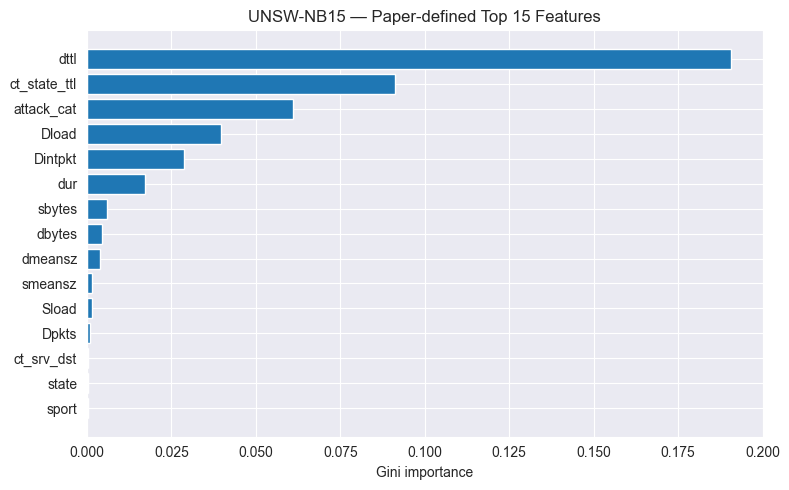

Saved plot to: ../data/UNSW-NB15_rf_top15.png


In [7]:
# Map overall importances to just the selected features
feat_to_idx = {name: i for i, name in enumerate(feature_names)}
sel_importances = [rf.feature_importances_[feat_to_idx[f]] for f in top_feats]

# Plot
plt.figure(figsize=(8,5))
order = np.argsort(sel_importances)
plt.barh(range(len(top_feats)), np.array(sel_importances)[order])
plt.yticks(range(len(top_feats)), [top_feats[i] for i in order])
plt.xlabel("Gini importance")
plt.title("UNSW-NB15 — Paper-defined Top 15 Features")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=220)
plt.show()
print("Saved plot to:", OUT_PNG)

# 7) Export the reduced dataset

In [8]:
# Ensure label_col is defined (earlier we used label_col = df.columns[-1] or 'label')
reduced = df[top_feats + [label_col]]
reduced.to_csv(OUT_REDUCED, index=False)
print("Saved:", OUT_REDUCED, "→", reduced.shape)
reduced.head(3)

Saved: ../data/UNSW-NB15_top15.csv → (1491445, 16)


,state,ct_state_ttl,attack_cat,sbytes,smeansz,Sload,dmeansz,Dpkts,Dload,dttl,dur,dbytes,sport,ct_srv_dst,Dintpkt,Label
0,3,1,12,918,77,28050.421880,1065,24,815794.187500,252,0.240139,25552,5201,2,9.570304,1
1,3,1,2,1362,97,4233.619141,45,6,749.668518,252,2.390390,268,28802,2,474.259406,1
2,3,1,12,8168,583,346366.812500,45,6,10228.894530,252,0.175190,268,35014,1,33.287000,1


# 8) Confirmation of correct data

In [9]:
# No NaNs?
print("NaNs in reduced:", reduced.isna().sum().sum())

# Train/valid columns match selected features?
print("Selected feature count:", len(top_feats))
print("First 5 selected features:", top_feats[:5])

# Class balance (on full reduced set; Section 3 will split again if needed)
reduced[label_col].value_counts(normalize=True).round(4)

NaNs in reduced: 0
Selected feature count: 15
First 5 selected features: ['state', 'ct_state_ttl', 'attack_cat', 'sbytes', 'smeansz']


Label
0    0.961
1    0.039
Name: proportion, dtype: float64